In [ ]:
%%capture
!pip install tensorflow_text
!git clone https://github.com/Jmkernes/PAR-Transformer-XL.git
%cd PAR-Transformer-XL/

In [613]:
import logging
logging.info("\n\n~~~~~~~~ Importing Modules ~~~~~~~~\n")

import os
import time
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
from data_utils import DataManager
from utils import print_bar, visualize_pi_weights
from par_model import PARTransformerXL
from par_model import create_lookahead_mask, positional_encoding

tf.debugging.enable_check_numerics()
tf.autograph.set_verbosity(0)

def load_datasets(train, val, test):
    """Load the wikitext2 train, validation and test data"""
    logging.info(f"\nLoading training data from: {train}")
    config = {'tfrecords_directory': train,'sp_model_prefix': 'wiki2_12k'}
    train_dm = DataManager.initialize_from_tfrecord(config)

    logging.info(f"\nLoading validation data from: {val}")
    config['tfrecords_directory'] = val
    valid_dm = DataManager.initialize_from_tfrecord(config)

    logging.info(f"\nLoading testing data from: {test}\n")
    config['tfrecords_directory'] = test
    test_dm = DataManager.initialize_from_tfrecord(config)

    return train_dm, valid_dm, test_dm

class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, decay_steps, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.max_lr = max_lr
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.pi = 3.1415927
    def __call__(self, step):
        linear = self.max_lr*(step/self.warmup_steps)
        cosine = 0.5*self.max_lr*(1+tf.math.cos(self.pi*tf.math.maximum(step-self.warmup_steps, 0)/self.decay_steps))
        return tf.math.minimum(linear, cosine)    

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


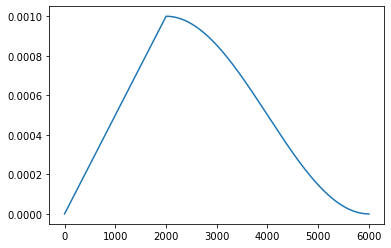

In [614]:
learning_rate = CosineSchedule(1e-3, 4000, 2000)
plt.plot(learning_rate(tf.range(6000.)))

In [615]:
# checkpointing and tensorboard params
model_name='base'#datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# data params
train_directory='data/wikitext2_bsz32_seqlen32_tfrecords_train'
valid_directory='data/wikitext2_bsz32_seqlen32_tfrecords_valid'
test_directory='data/wikitext2_bsz32_seqlen32_tfrecords_test'

# model params
# d_model=256
# num_heads=8
# d_ffn=1024
# num_layers=12
# mem_len=32
# dropout_rate=0.1
# cutoffs=[250, 2500]
# proj_factor=4
# proj_dims=[]

# small version for testing
d_model=64
num_heads=2
d_ffn=128
num_layers=4
mem_len=32
dropout_rate=0.1
cutoffs=[250, 2500]
proj_factor=2
proj_dims=[]

# learning params
warmup_steps=4000
tau_start=2.0
tau_end=0.2
epochs=5
tau_is_trainable=False
opt_name='adam'

In [662]:
# Take care of some flags logic beyond simple constraints.
if d_model%num_heads:
    raise ValueError('Number of heads must divide d_model')

train_dm, valid_dm, test_dm = load_datasets(train_directory, valid_directory, test_directory)

## Set global constants inferred from the training data.
BATCH_SIZE = train_dm.batch_size
SEQ_LEN = train_dm.seq_len
VOCAB_SIZE = train_dm.tokenizer.vocab_size().numpy()
DATASET_SIZE = train_dm.ds_size.numpy()
MAX_POSITION = max(512, mem_len+SEQ_LEN)

# Take care of additional constraints on inputs that needed the vocab size
if any([z>=VOCAB_SIZE for z in cutoffs]) or len(set(cutoffs))!=len(cutoffs):
    raise ValueError("Cutoffs must not exceed {VOCAB_SIZE} or contain duplicates.")
if cutoffs:
    cutoffs.sort()
    cutoffs.append(VOCAB_SIZE)

### Define learning rate schedule and simulated annealing schedule for gumbel softmax temperature tau.
logging.info(f"\n\nInitializing {opt_name} optimizer with {warmup_steps} warmup steps.")
learning_rate = CosineSchedule(max_lr=5e-4, warmup_steps=4000, decay_steps=DATASET_SIZE*epochs-4000)
optimizer = tf.keras.optimizers.get(opt_name)
optimizer.learning_rate = learning_rate

if tau_is_trainable:
    logging.info(f"\n\nInitializing exponential tau decay: {tau_start}-->{tau_end}.\n")
tau = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=tau_start,
    decay_steps=DATASET_SIZE*epochs,
    decay_rate=tau_end
)

In [661]:
# Setup the model
tf.keras.backend.clear_session()
config = {
    'd_model': d_model,
    'num_heads': num_heads,
    'max_position': MAX_POSITION,
    'd_ffn': d_ffn,
    'num_layers': num_layers,
    'mem_len': mem_len,
    'vocab_size': VOCAB_SIZE,
    'dropout_rate': dropout_rate,
    'cutoffs': cutoffs,
    'proj_factor': proj_factor,
    'proj_dims': proj_dims,
}
logging.info("\n\nInitializing model...")
logging.info("Model parameters:")
logging.info(config)
pos_enc = positional_encoding(MAX_POSITION, d_model)
lookahead_mask = create_lookahead_mask(MAX_POSITION, MAX_POSITION)
model = PARTransformerXL(**config)

# Build model by feeding in sample training data
x_temp, y_temp = next(iter(train_dm.get_inp_tar_pairs()))
model(x_temp, None, labels=y_temp, training=False)

# make tau untrainable
if not tau_is_trainable:
    for layer in model.layers:
        if hasattr(layer, 'tau'):
            layer.tau = tf.cast(tf.constant(1.), tf.float32)

In [618]:
# print out model summary
logging.info("\nModel summary:")
logging.info(model.summary())

# Define metrics
train_loss = tf.keras.metrics.Mean()
valid_loss = tf.keras.metrics.Mean()
train_perp = tf.keras.metrics.Mean()
valid_perp = tf.keras.metrics.Mean()

logging.info("\n\nDefining training and evaluation steps...")
# Define the training and evaluation steps via tf functions
@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(inp, x_mems=x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

@tf.function
def evaluation_step(x, x_mems, labels, tau):
    loss, mems = model(x, x_mems=x_mems, labels=labels, tau=tau, training=False)
    valid_loss(loss)
    valid_perp(tf.math.exp(loss))
    return mems

def evaluation(dataset, tau):
    x_mems = None
    for x, lbl in dataset:
        x_mems = evaluation_step(x, x_mems, lbl, tau)

Model: "par_transformer_xl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  768000    
_________________________________________________________________
adaptive_softmax (AdaptiveSo multiple                  255250    
_________________________________________________________________
stochastic_block (Stochastic multiple                  37763     
_________________________________________________________________
stochastic_block_1 (Stochast multiple                  37763     
_________________________________________________________________
stochastic_block_2 (Stochast multiple                  37763     
_________________________________________________________________
stochastic_block_3 (Stochast multiple                  37763     
_________________________________________________________________
inp_dropout (Dropout)        multiple           

In [660]:
# Set up TensorBoard
logging.info("\n\nInitializing TensorBoard...")
train_log_dir = './logs/' + model_name + '/train'
test_log_dir = './logs/' + model_name + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# # TODO: FIGURE OUT WHAT TO DO HERE, HOW TO LOAD TensorBoard
# Maybe try os.system()? Or push this into another loading script? idk
# os.system('tensorboard --logdir ./logs')

# Configure datasets for training
logging.info("\n\nConfiguring datasets for training. Caching, prefetching...")
glob_step = tf.Variable(0, dtype=tf.int64) # This will break tf.summary if we use int32
train_ds = train_dm.get_inp_tar_pairs().cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)
iterator=iter(train_ds)

# Set up checkpointing to periodically save the model every epoch
checkpoint_path = "./checkpoints/train/"+model_name
logging.info(f"\n\nInitializing checkpoints. Models will be saved to {checkpoint_path}")
ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer,
    glob_step=glob_step,
    iterator=iterator
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    try:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        logging.info('Latest checkpoint restored!!')
    except:
        logging.warning("Model may have changed, could not restore checkpoint.")

In [620]:
# log initial checkpoint
ckpt_save_path = ckpt_manager.save()
logging.info(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

In [624]:
# Run the actual training loop!
logging.info("\n\n~~~~~~~~~~ Beginning training ~~~~~~~~~~")
for epoch in range(epochs):

#     logging.info('-'*10+f' Epoch {epoch+1}/{epochs} '+'-'*10)
    print('-'*10+f' Epoch {epoch+1}/{epochs} '+'-'*10)
    start = time.time()
    for x in [train_loss, valid_loss, train_perp, valid_perp]:
        x.reset_states()
    mems = None

    for step, (inp, lbl) in enumerate(train_ds.take(50)):

        mems = train_step(inp, mems, lbl, tau(glob_step))

        diff = (time.time()-start)/(step+1)
        print_bar(step, 50, diff, train_loss.result().numpy())

        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_loss.result(), step=glob_step)
            tf.summary.scalar('train_perp', train_perp.result(), step=glob_step)
            tf.summary.scalar('tau', tau(glob_step), step=glob_step)
        glob_step.assign_add(1)

    evaluation(valid_ds.take(5), tau(glob_step))
    with test_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_loss.result(), step=glob_step)
        tf.summary.scalar('valid_perp', valid_perp.result(), step=glob_step)

    ckpt_save_path = ckpt_manager.save()
    logging.info(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
    visualize_pi_weights(model)
plt.show()

---------- Epoch 1/5 ----------
Iteration 50/50: [==========>] 4.45 it/s. Est: 00m 00s Loss: 8.261
---------- Epoch 2/5 ----------
Iteration 50/50: [==========>] 3.70 it/s. Est: 00m 00s Loss: 8.177
---------- Epoch 3/5 ----------
Iteration 50/50: [==========>] 3.64 it/s. Est: 00m 00s Loss: 8.053
---------- Epoch 4/5 ----------
Iteration 50/50: [==========>] 3.71 it/s. Est: 00m 00s Loss: 7.865
---------- Epoch 5/5 ----------
Iteration 50/50: [==========>] 3.87 it/s. Est: 00m 00s Loss: 7.647


In [626]:
%tensorboard --logdir logs

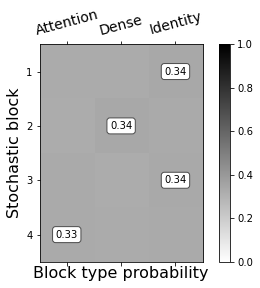

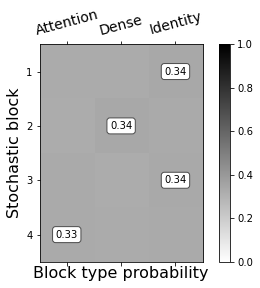

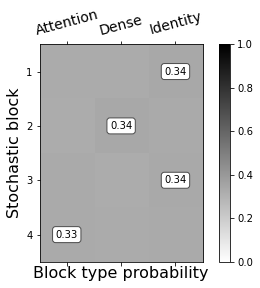

In [735]:
visualize_pi_weights(model)
visualize_pi_weights(model)
visualize_pi_weights(model)
plt.show()

In [732]:
len(weights)

4

In [630]:
!ls checkpoints/train/base

checkpoint                 ckpt-4.index
ckpt-2.data-00000-of-00001 ckpt-5.data-00000-of-00001
ckpt-2.index               ckpt-5.index
ckpt-3.data-00000-of-00001 ckpt-6.data-00000-of-00001
ckpt-3.index               ckpt-6.index
ckpt-4.data-00000-of-00001


In [667]:
# load in a model from checkpoint

new_model = PARTransformerXL(**config)
new_model.build(input_shape=[32, 32])
# make tau untrainable
if not tau_is_trainable:
    for layer in new_model.layers:
        if hasattr(layer, 'tau'):
            layer.tau = tf.cast(tf.constant(1.), tf.float32)

In [657]:
ckpt = tf.train.Checkpoint(
    model=new_model
)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [666]:
for i in range(len(model.weights)):
    print(f"Weights {i}: {tf.experimental.numpy.allclose(new_model.weights[i], model.weights[i])}")

Weights 0: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 1: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 2: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 3: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 4: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 5: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 6: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 7: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 8: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 9: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 10: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 11: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 12: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 13: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 14: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 15: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights 16: ndarray<tf.Tensor(True, shape=(), dtype=bool)>
Weights

In [638]:
# x_temp, y_temp = next(iter(train_dm.get_inp_tar_pairs()))
# new_model(x_temp, None, labels=y_temp, training=False)
# 5

Cause: could not parse the source code of <function DataManager.get_inp_tar_pairs.<locals>.<lambda> at 0x7fbb8f5b0820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function DataManager.get_inp_tar_pairs.<locals>.<lambda> at 0x7fbb8f5b0820>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


5

In [603]:
!rm -r checkpoints/
!rm -r logs/

In [622]:
init_weights = model.weights

# Old stuff

In [436]:
train_dm.ds_size.numpy()

2827

In [447]:
from pprint import pprint
pprint("Model parameters:\n",config)

AttributeError: 'dict' object has no attribute 'write'

## Load the wikitext2 train, validation and test data

In [416]:
config = {'tfrecords_directory':'data/wikitext2_bsz32_seqlen32_tfrecords_train',
                'sp_model_prefix': 'wiki2_12k'}
train_dm = DataManager.initialize_from_tfrecord(config)

config['tfrecords_directory'] = 'data/wikitext2_bsz32_seqlen32_tfrecords_valid'
valid_dm = DataManager.initialize_from_tfrecord(config)

config['tfrecords_directory'] = 'data/wikitext2_bsz32_seqlen32_tfrecords_test'
test_dm = DataManager.initialize_from_tfrecord(config)

Loading tokenizer from wiki2_12k.model...
Loading tfrecords from directory
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbdb18e160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbdb18e160>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbd9971940>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function load_tfrecord_ds_from_files.<locals>.<lambda> at 0x7fbbd9971940>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

## Initialize model architecture

In [417]:
train_dm.ds_size

<tf.Tensor: shape=(), dtype=int64, numpy=2827>

In [418]:
tf.keras.backend.clear_session()

config = {
    'd_model':64, 
    'num_heads':4, 
    'max_position':512, 
    'd_ffn':128,
    'num_layers':6, 
    'mem_len':32, 
    'vocab_size':12000,
    'dropout_rate':0.1, 
    'cutoffs':[250, 2500, 12000], 
    'proj_factor':2, 
    'proj_dims':None,
}

ds_size = train_dm.ds_size
max_position = config['max_position']
pos_enc = positional_encoding(max_position, config['d_model'])
lookahead_mask = create_lookahead_mask(max_position, max_position)
model = PARTransformerXL(**config)

In [419]:
train_ds = train_dm.get_inp_tar_pairs()
x, y = next(iter(train_ds))
model(x, None, labels=y, training=True)
model.summary()

Model: "par_transformer_xl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  768000    
_________________________________________________________________
adaptive_softmax (AdaptiveSo multiple                  255250    
_________________________________________________________________
stochastic_block (Stochastic multiple                  37764     
_________________________________________________________________
stochastic_block_1 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_2 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_3 (Stochast multiple                  37764     
_________________________________________________________________
stochastic_block_4 (Stochast multiple           

### Create simulated annealing schedule for gumbel softmax tau. We use exponential decay.

In [420]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [421]:
# Define metrics
train_loss = tf.keras.metrics.Mean()
valid_loss = tf.keras.metrics.Mean()
train_perp = tf.keras.metrics.Mean()
valid_perp = tf.keras.metrics.Mean()

In [422]:
# Define tau schedule, plus must specify total number of global steps
EPOCHS = 3
tot_steps = int(EPOCHS*ds_size.numpy())

tau_is_trainable = False

tau = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2.0,
    decay_steps = tot_steps,
    decay_rate = 0.1
)

print(f"Epochs: {EPOCHS}. Total steps: {tot_steps}")

Epochs: 3. Total steps: 8481


In [448]:
# Set up training step and optimizer.

learning_rate = CustomSchedule(config['d_model'], 4000)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(x, x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

In [449]:
@tf.function
def evaluation_step(x, x_mems, labels, tau):
    loss, mems = model(x, x_mems=x_mems, labels=labels, tau=tau, training=False)
    perplexity = tf.math.exp(loss)
    valid_loss(loss)
    valid_perp(perplexity)
    return mems

def evaluation(dataset, tau):
    x_mems = None
    for x, lbl in dataset:
        x_mems = evaluation_step(x, x_mems, lbl, tau)

# @tf.function
# def evaluation(dataset, tau):
#     mems = None
#     for x, lbl in dataset:
#         loss, mems = model(x, x_mems=mems, labels=lbl, tau=tau, training=False)
#         perplexity = tf.math.exp(loss)
#         valid_loss(loss)
#         valid_perp(perplexity)

In [450]:
# Set up Checkpoints

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    try:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')
    except:
        print("Model may have changed, could not restore checkpoint.")

In [451]:
# make tau untrainable
if not tau_is_trainable:
    for layer in model.layers:
        if hasattr(layer, 'tau'):
            layer.tau = tf.cast(tf.constant(1.), tf.float32)

In [452]:
# Set up TensorBoard

%load_ext tensorboard
train_log_dir = './logs' + '/train'
test_log_dir = './logs' + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [453]:
train_ds = train_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_dm.get_inp_tar_pairs().prefetch(tf.data.AUTOTUNE)

In [454]:
glob_step

In [455]:
%tensorboard --logdir ./logs
history={'loss':[], 'tau':[]}
glob_step = 0
num_batches = train_dm.ds_size.numpy()

for epoch in range(EPOCHS):
    
    print('-'*10,f' Epoch {epoch+1} ', '-'*10)
    start = time.time()
    train_loss.reset_states()
    mems = None
    for step, (inp, lbl) in enumerate(train_ds):
        
        mems = train_step(inp, mems, lbl, tau(glob_step))
        diff = (time.time()-start)/(step+1)
        printBar(step, num_batches, diff, train_loss.result().numpy())
                
        history['loss'].append(train_loss.result().numpy())
        history['tau'].append(tau(glob_step).numpy())
        
        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_loss.result(), step=glob_step)
            tf.summary.scalar('train_perp', train_perp.result(), step=glob_step)
            tf.summary.scalar('tau', tau(glob_step), step=glob_step)        
        glob_step += 1
     
    evaluation(valid_ds, tau(glob_step))
    with test_summary_writer.as_default():
        tf.summary.scalar('valid_loss', valid_loss.result(), step=glob_step)
        tf.summary.scalar('valid_perp', valid_perp.result(), step=glob_step)
    
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

----------  Epoch 1  ----------


AttributeError: in user code:

    <ipython-input-448-f7b0885aefec>:9 train_step  *
        loss, mems = model(x, x_mems, labels=labels, training=True, tau=tau)
    /Users/jonathankernes/Documents/NLP/transformer-xl/PARtransformer/par_model.py:261 call  *
        x = self.embed(x)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/embeddings.py:190 call
        dtype = K.dtype(inputs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:1418 dtype
        return x.dtype.base_dtype.name
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:798 __getattribute__
        raise e
    /Users/jonathankernes/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:788 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)

    AttributeError: 'RMSprop' object has no attribute 'dtype'


In [457]:
tau(tf.Variable(0))

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

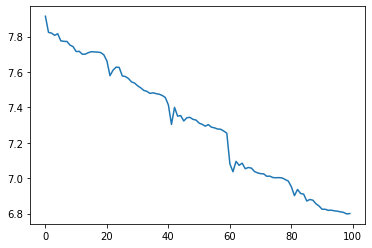

In [302]:
plt.plot(history['loss'])

In [152]:
for i in range(2,6):
    print(f"Layer {i-1}: {model.layers[i].pi.numpy()}")
    
for i in range(2,6):
    print(f"Layer {i-1}: {model.layers[i].tau.numpy()}")

Layer 1: [0.32119352 0.32047126 0.35673234]
Layer 2: [0.3197162  0.34020415 0.35368592]
Layer 3: [0.35318667 0.28377616 0.34028876]
Layer 4: [0.3391504  0.30977973 0.3718491 ]
Layer 1: 1.0
Layer 2: 1.0
Layer 3: 1.0
Layer 4: 1.0


In [ ]:
# Checkpointing and model saving

# Initializing a checkpoint manager
opt = tf.keras.optimizers.Adam(0.1)
dataset = toy_dataset()
iterator = iter(dataset)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)


# Restoring from a previous checkpoint
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored from {manager.latest_checkpoint})
else:
    print("Initializing from scratch.")

# Keep track of global step manually in the checkpoint
ckpt.step.assign_add(1)
if int(ckpt.step) % 10 == 0:
  save_path = manager.save()
  print(f"Saved checkpoint for step {int(ckpt.step)}: {save_path}")

<Figure size 144x432 with 0 Axes>

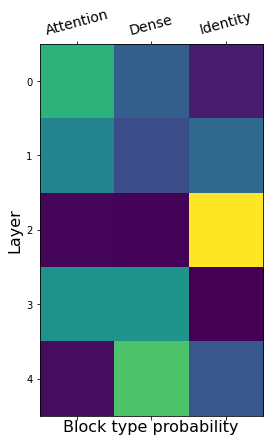

In [476]:
x = np.random.rand(5,3)
x /= np.sum(x, axis=1, keepdims=True)
fig = plt.figure(figsize=(2, 6))
# ax = fig.add_subplot(1, 1, 1)
# # plot the attention weights
# ax.matshow(x, cmap='viridis')
# fontdict = {'fontsize': 20}
# ax.set_xticks(range(x.shape[1]))
# ax.set_yticks(range(x.shape[0]))
# ax.set_xticklabels(['Attn', 'FFN', 'Id'], fontdict=fontdict, rotation=45)
# ax.set_yticklabels([i for i in range(x.shape[1])], fontdict=fontdict)
# ax.set_xlabel(f'Block type probability {1}')
# ax.set_ylabel(f'Layer')
# plot the attention weights
plt.matshow(x, cmap='viridis')
fontdict = {'fontsize': 20}
plt.xticks(range(x.shape[1]), ['Attention', 'Dense', 'Identity'], rotation=15, size=14)
plt.yticks(range(x.shape[0]), range(x.shape[0]))
plt.xlabel(f'Block type probability', size=16)
plt.ylabel(f'Layer', size=16)
plt.show()

In [481]:
@tf.function
def train_step(inp, x_mems, labels, tau):
    with tf.GradientTape() as tape:
        loss, mems = model(x, x_mems=x_mems, labels=labels, training=True, tau=tau)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_perp(tf.math.exp(loss))
    return mems

[None, None, None, None]
[None, None, 5, None]


In [508]:
@tf.function
def train_step(inp, mems, labels):
    loss, mems = model(inp, mems, labels, 2.0, True, None)
    return mems

In [509]:
train_ds = train_dm.get_inp_tar_pairs()

In [510]:
inp, lbl = next(iter(train_ds))

In [511]:
_, _ = model(inp, None, lbl, 2.0, True)

In [512]:
train_step.get_concrete_function(inp, None, lbl)

<ConcreteFunction train_step(inp, mems=None, labels) at 0x7FBB6D8579A0>

In [516]:
x = tf.Variable(0, dtype=tf.int64)
print(x)
x.assign_add(1)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=0>
<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=1>


In [494]:
# train_step(inp, inp, labels=lbl, tau=2.0)
print(train_step.pretty_printed_concrete_signatures())

In [493]:
x, x_mems=None, labels=None, tau=None, training=None, pad_mask=None

Help on PARTransformerXL in module par_model object:

class PARTransformerXL(tensorflow.python.keras.engine.training.Model)
 |  PARTransformerXL(*args, **kwargs)
 |  
 |  `Model` groups layers into an object with training and inference features.
 |  
 |  Arguments:
 |      inputs: The input(s) of the model: a `keras.Input` object or list of
 |          `keras.Input` objects.
 |      outputs: The output(s) of the model. See Functional API example below.
 |      name: String, the name of the model.
 |  
 |  There are two ways to instantiate a `Model`:
 |  
 |  1 - With the "Functional API", where you start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally you create your model from inputs and outputs:
 |  
 |  ```python
 |  import tensorflow as tf
 |  
 |  inputs = tf.keras.Input(shape=(3,))
 |  x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
 |  outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
 |  model = tf.keras.Mod

In [522]:
def visualize_pi_weights(model):
    weights = []
    for layer in model.layers:
        if hasattr(layer, 'pi'):
            weight = layer.pi
            weight /= tf.reduce_sum(weight)
            weights.append(layer.pi)
    num_blocks = len(weights)
    weights = tf.stack(weights, 0).numpy()

    plt.matshow(weights, cmap='viridis')
    plt.xticks(range(3), ['Attention', 'Dense', 'Identity'], rotation=15, size=14)
    plt.yticks(range(num_blocks), range(1, num_blocks+1))
    plt.xlabel(f'Block type probability', size=16)
    plt.ylabel(f'Stochastic block', size=16)
    plt.show()

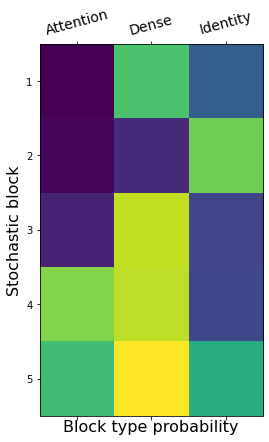

In [526]:
weights = np.random.rand(5,3)
plt.matshow(weights, cmap='viridis')
plt.xticks(range(3), ['Attention', 'Dense', 'Identity'], rotation=15, size=14)
plt.yticks(range(5), range(1, 5+1))
plt.xlabel(f'Block type probability', size=16)
plt.ylabel(f'Stochastic block', size=16)
plt.show()

In [ ]:
start = time.time()
for i in range(100):
    time.sleep(0.01)
    x = 5/np.sqrt(i+1)
    diff = (time.time()-start)/(i+1)
    printBar(i, 100, diff, x)